In [1]:
import numpy as np
import os
import pandas as pd
from sklearn import svm
import time
import warnings
warnings.filterwarnings("ignore")

# Data processing

## Data Description


Due to the limited computational resource, we focus on chromosome 16 with only one alternative allele.<br>
We transform data into datafram. Each column is the position of SNPs and each row is the sample ID. We category total 26 groups into 6 ancestry group and replace each ancestry group with number 1-6.<br>
We only care about where mutation appear for each sample. So, we replace 0 (homozygous reference) to 0 (no variant), and 1 or 2(heterozygous and homozygous non-reference) to 1 (variant) for each position through all samples.

In [4]:
%%bash

file=/datasets/cs284-sp21-A00-public/ps2/ps2_pca.genotypes.vcf.gz

zcat $file | head -253 | tail -1 > ~/cse284_SP21_final/data/snps_sample.tab

bcftools query -e'AF<0.01' -e'AF>0.99' -f "%CHROM %POS [%GT\t]\n" $file | \
  sed 's/0|0/0/g' | sed 's/0|1/1/g' | sed 's/1|0/1/g' | sed 's/1|1/2/g' | \
  grep -v "|" \
  > ~/cse284_SP21_final/data/snps.tab

In [2]:
temp = []
with open("/home/yul579/cse284_SP21_final/data/snps.tab", "r") as f:
    for line in f:
        #read line 
        sample = line.strip().split()
        temp.append(sample)
samples = []
with open("/home/yul579/cse284_SP21_final/data/snps_sample.tab", "r") as f:
    for line in f:
        samples = line.strip().split()

In [3]:
cols = ["CHROM","POS"]
cols = cols+samples[9:]

In [4]:
snps = pd.DataFrame(temp, columns=cols)

In [5]:
snps["SNPs_POS"] = "chr"+snps["CHROM"] +":"+snps["POS"]

In [6]:
snps = snps.iloc[:,2:]
snps = snps.set_index('SNPs_POS')

In [7]:
snps = snps.transpose()

In [8]:
temp = []
temp2 = []
with open("/datasets/cs284-sp21-A00-public/ps2/ps2_reference_labels.csv", "r") as f:
    for line in f:
        s, pop = line.strip().split(",")
        temp.append(pop)
        temp2.append(s)

In [9]:
snps = snps.drop(["NA10847","NA18923","NA19700"])

In [10]:
snps["group_id"] = temp

In [11]:
snps.head()

SNPs_POS,chr16:88165,chr16:95254,chr16:97354,chr16:101263,chr16:103423,chr16:103456,chr16:105320,chr16:105444,chr16:107275,chr16:110165,...,chr16:90125947,chr16:90127080,chr16:90132786,chr16:90134325,chr16:90141355,chr16:90141477,chr16:90148979,chr16:90149922,chr16:90163275,group_id
HG00096,0,0,0,1,1,0,1,1,1,1,...,0,0,0,0,2,2,2,0,2,GBR
HG00097,0,0,0,2,2,0,2,2,2,2,...,0,0,0,0,2,2,2,0,2,GBR
HG00099,0,0,0,2,2,0,2,2,2,2,...,0,1,0,0,0,2,2,1,2,GBR
HG00100,0,0,0,1,1,0,1,1,1,1,...,0,1,0,0,1,2,2,1,1,GBR
HG00101,0,0,0,2,2,0,2,2,2,2,...,0,1,0,0,1,2,2,1,1,GBR


In [12]:
list(snps. index) == temp2

True

In [13]:
def ancestry_type(row):
    if row.group_id in ["ACB","ASW"]:
        return "Admixed African"
    elif row.group_id in ["GIH","BEB","ITU"]:
        return "South Asian"
    elif row.group_id in ["CDX","CHB","CHS","JPT","KHV"]:
        return "East Asian"
    elif row.group_id in ["CEU","FIN","GBR","IBS","TSI"]:
        return "European"
    elif row.group_id in ["CLM","MXL","PEL","PJL","PUR","STU"]:
        return "American"
    elif row.group_id in ["LWK","MSL","YRI","ESN","GWD"]:
        return "African"
    else:
        return None
snps["ancestry_group"] = snps.apply(ancestry_type, axis = 1)

In [14]:
def code_group(row):
    if row.ancestry_group == "Admixed African":
        return 1
    elif row.ancestry_group == "South Asian":
        return 2
    elif row.ancestry_group == "East Asian":
        return 3
    elif row.ancestry_group == "European":
        return 4
    elif row.ancestry_group == "American":
        return 5
    elif row.ancestry_group == "African":
        return 6
    else:
        return 0

In [15]:
snps["class"] = snps.apply(code_group, axis = 1)

In [16]:
snps.head()

SNPs_POS,chr16:88165,chr16:95254,chr16:97354,chr16:101263,chr16:103423,chr16:103456,chr16:105320,chr16:105444,chr16:107275,chr16:110165,...,chr16:90132786,chr16:90134325,chr16:90141355,chr16:90141477,chr16:90148979,chr16:90149922,chr16:90163275,group_id,ancestry_group,class
HG00096,0,0,0,1,1,0,1,1,1,1,...,0,0,2,2,2,0,2,GBR,European,4
HG00097,0,0,0,2,2,0,2,2,2,2,...,0,0,2,2,2,0,2,GBR,European,4
HG00099,0,0,0,2,2,0,2,2,2,2,...,0,0,0,2,2,1,2,GBR,European,4
HG00100,0,0,0,1,1,0,1,1,1,1,...,0,0,1,2,2,1,1,GBR,European,4
HG00101,0,0,0,2,2,0,2,2,2,2,...,0,0,1,2,2,1,1,GBR,European,4


## Data split

We randomly split the data into 75% train and 25% test.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
#Select the columns of features
X=snps.loc[: , (snps.columns != 'group_id') & (snps.columns != 'ancestry_group') & (snps.columns != 'class')]

In [19]:
X = X.applymap(lambda x: 1 if int(x) >0 else 0)
X.head()

SNPs_POS,chr16:88165,chr16:95254,chr16:97354,chr16:101263,chr16:103423,chr16:103456,chr16:105320,chr16:105444,chr16:107275,chr16:110165,...,chr16:90125731,chr16:90125947,chr16:90127080,chr16:90132786,chr16:90134325,chr16:90141355,chr16:90141477,chr16:90148979,chr16:90149922,chr16:90163275
HG00096,0,0,0,1,1,0,1,1,1,1,...,0,0,0,0,0,1,1,1,0,1
HG00097,0,0,0,1,1,0,1,1,1,1,...,0,0,0,0,0,1,1,1,0,1
HG00099,0,0,0,1,1,0,1,1,1,1,...,0,0,1,0,0,0,1,1,1,1
HG00100,0,0,0,1,1,0,1,1,1,1,...,0,0,1,0,0,1,1,1,1,1
HG00101,0,0,0,1,1,0,1,1,1,1,...,0,0,1,0,0,1,1,1,1,1


In [20]:
#Select the class column
Y=snps.loc[: , snps.columns == 'class']
Y.head()

SNPs_POS,class
HG00096,4
HG00097,4
HG00099,4
HG00100,4
HG00101,4


In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

# Methods

In [201]:
#chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#random
import random
#PCA
from sklearn.decomposition import PCA
## info_gain
from collections import defaultdict
from math import log

## chi2 selection

Chi-square test is used for categorical features in a dataset. We calculate Chi-square between each feature and the target and select the desired number of features with best Chi-square scores. It determines if the association between two categorical variables of the sample would reflect their real association in the population.

In [202]:
def chi2_selection(x_train,x_test,y_train,y_test,num):
    test = SelectKBest(score_func=chi2, k=num).fit(x_train, y_train)
    X_select_index = test.get_support(indices=True)
    return X_select_index

## Info Gain

Information gain is the reduction in entropy or surprise by transforming a dataset and is often used in training decision trees. Information gain is calculated by comparing the entropy of the dataset before and after a transformation.

In [226]:
def calcShannonEnt(Y):
    numEntries = len(Y)
    labelCounts = defaultdict(int)
    for label in Y:
        labelCounts[label] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

def calcInfoGain(dataset,Y):
    baseEntropy = calcShannonEnt(Y)
    InfoGain_list = []
    for i in range(dataset.shape[0]):
        subset_list = [[],[],[]]
        for j in range(dataset.shape[1]):
            subset_list[int(dataset[i,j])].append(j)
        newEntropy = 0.0
        splitInfo = 0.0
        for value in [0,1,2]:
            if len(subset_list[value])==0:
                continue
            prob = len(subset_list[value])/float(dataset.shape[1])
            newEntropy += prob * calcShannonEnt(Y[subset_list[value]])
            splitInfo += -prob * log(prob, 2)
        infoGain = baseEntropy - newEntropy
        if (splitInfo == 0):
            continue
        infoGainRatio = infoGain / splitInfo
        InfoGain_list.append(infoGainRatio)
    return InfoGain_list

In [228]:
InfoGain_list = calcInfoGain(x_train.to_numpy().transpose(),y_train.to_numpy().transpose()[0])
rank_infoGain = np.array(InfoGain_list).argsort()

## Random Select

random select certain number of SNPs 

In [44]:
def random_select(k):
    return random.sample(range(28622), k)

## PCA

In [31]:
def PCA_comparison(x_train,x_test):
    pca = PCA(n_components=4).fit(x_train)
    train_pca = pca.transform(x_train)
    test_pca = pca.transform(x_test)
    return train_pca,test_pca

# Classification Results

In [32]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

import time

## SVM

In [232]:
def simple_SVM(X,Y,test_X,test_Y,method='svm_linear'):
    #time0=time.time()
    if method=='svm_linear' or method==0:
        clf = svm.SVC(kernel='linear')
    elif method=='KNeighbors' or method==1:
        clf = KNeighborsClassifier()
    elif method=='LogisticRegression' or method==2:
        clf = LogisticRegression(penalty='l2')
    elif method=='RandomForest' or method==3:
        clf = RandomForestClassifier(n_estimators=8)
    elif method=='DecisionTree' or method==4:
        clf = tree.DecisionTreeClassifier()
    elif method=='AdaBoost' or method==5:
        clf = AdaBoostClassifier()
    elif method=='Bayes' or method==6:
        clf = MultinomialNB(alpha=0.01)
    else:
        print('Not implied!')
        return None
    
    clf.fit(X,Y)
    #print('Train time:',int(time.time()-time0))
    train_score = clf.score(X, Y)
    test_score = clf.score(test_X, test_Y)
    #print('train acc:',train_score)
    #print('test acc:',test_score)
    return [train_score,test_score]

In [233]:
def classfier_code(num):
    if num == 0:
        return "svm_linear"
    elif num==1:
        return "KNeighbors"
    elif num==2:
        return "LogisticRegression"
    elif num==3:
        return "RandomForest"
    elif num==4:
        return "DecisionTree"
    elif num==5:
        return "AdaBoost"
    elif num==6:
        return "Bayes"
    else:
        return None

## Comparison

In [239]:
result = []
for num in [10,50,100]:
    for clf_num in range(2,7):
        temp = []
        temp.append(num)
        temp.append(classfier_code(clf_num))
        #chi2
        idx = chi2_selection(x_train,x_test,y_train,y_test,num)
        chi2_r = simple_SVM(x_train.iloc[:,idx],y_train,x_test.iloc[:,idx],y_test,clf_num)
        temp.append(chi2_r[1])
        #info gain
        info_r = simple_SVM(x_train.iloc[:,rank_infoGain[-num:]],y_train,x_test.iloc[:,rank_infoGain[-num:]],y_test,clf_num)
        temp.append(info_r[1])
        #random
        rl = random_select(num)
        random_r = simple_SVM(x_train.iloc[:,rl],y_train,x_test.iloc[:,rl],y_test,clf_num)
        temp.append(random_r[1])
        result.append(temp)

Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 57
Train time: 56
Train time: 56
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 78
Train time: 72
Train time: 75
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0
Train time: 0


In [244]:
df = pd. DataFrame(result,columns = ["#SNPs", "classfier","chi2_accuracy","info_gain_accuracy","random_accuracy"])

In [245]:
df[df["#SNPs"]==10]

,#SNPs,classfier,chi2_accuracy,info_gain_accuracy,random_accuracy
0,10,LogisticRegression,0.608626,0.471246,0.477636
1,10,RandomForest,0.610224,0.450479,0.442492
2,10,DecisionTree,0.603834,0.444089,0.365815
3,10,AdaBoost,0.536741,0.444089,0.442492
4,10,Bayes,0.466454,0.466454,0.490415


In [246]:
df[df["#SNPs"]==50]

,#SNPs,classfier,chi2_accuracy,info_gain_accuracy,random_accuracy
5,50,LogisticRegression,0.650160,0.670927,0.685304
6,50,RandomForest,0.616613,0.599042,0.576677
7,50,DecisionTree,0.591054,0.554313,0.439297
8,50,AdaBoost,0.584665,0.597444,0.669329
9,50,Bayes,0.584665,0.645367,0.680511


In [247]:
df[df["#SNPs"]==100]

,#SNPs,classfier,chi2_accuracy,info_gain_accuracy,random_accuracy
10,100,LogisticRegression,0.674121,0.718850,0.707668
11,100,RandomForest,0.659744,0.678914,0.646965
12,100,DecisionTree,0.608626,0.587859,0.603834
13,100,AdaBoost,0.595847,0.643770,0.607029
14,100,Bayes,0.634185,0.746006,0.725240


In [ ]:
df[df["#SNPs"]==500]

In [ ]:
df[df["#SNPs"]==1000]

# Discussion

## overlap

In [251]:
import matplotlib.pyplot as plt
import matplotlib_venn as venn

ImportError: cannot import name 'matplotlib_venn' from 'matplotlib' (/opt/conda/lib/python3.8/site-packages/matplotlib/__init__.py)

In [ ]:
for num in [10,50,100]:
    chi2_idx = chi2_selection(x_train,x_test,y_train,y_test,num)
    info_idx = rank_infoGain[-num:]
    venn2([chi2_idx, info_idx],set_labels=('chi2', 'info_gain'))
    plt.show()

In [259]:
chi2_idx = chi2_selection(x_train,x_test,y_train,y_test,1000)
info_idx = rank_infoGain[-1000:]

In [262]:
intersection_set = set.intersection(set(chi2_idx), set(info_idx))
overlap_idx = list(intersection_set)

In [263]:
len(overlap_idx)

63

In [264]:
overlap = []
for clf_num in range(7):
    temp = []
    temp.append(classfier_code(clf_num))
    idx = chi2_selection(x_train,x_test,y_train,y_test,num)
    acc = simple_SVM(x_train.iloc[:,overlap_idx],y_train,x_test.iloc[:,overlap_idx],y_test,clf_num)
    temp.append(acc[1])
    overlap.append(temp)

Train time: 0
Train time: 0
Train time: 54
Train time: 0
Train time: 0
Train time: 0
Train time: 0


In [265]:
df_overlap = pd. DataFrame(overlap,columns = ["classfier","accuracy"])

In [266]:
df_overlap

,classfier,accuracy
0,svm_linear,0.635783
1,KNeighbors,0.573482
2,LogisticRegression,0.653355
3,RandomForest,0.599042
4,DecisionTree,0.539936
5,AdaBoost,0.527157
6,Bayes,0.523962


## classification_report

In [118]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

In [254]:
def predict_value(X,Y,test_X,test_Y):
    clf = LogisticRegression(penalty='l2') 
    clf.fit(X,Y)
    return clf.predict(test_X)

In [273]:
target_names = ["Admixed-African","South-Asian","East-Asian","European","American","African"]

In [ ]:
y_pred = predict_value(x_train,y_train,x_test,y_test)
report = classification_report(y_test, y_pred, target_names=target_names)

AttributeError: 'AxesSubplot' object has no attribute 'colorbar'

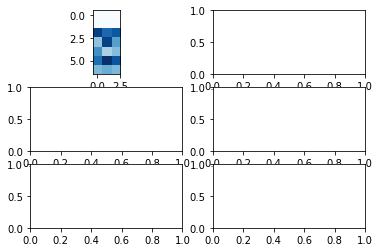

In [282]:
figure, axis = plt.subplots(3, 2)
count = 0
for num in [10]:
    #chi2
    chi2_idx = chi2_selection(x_train,x_test,y_train,y_test,num)
    y_pred_chi2 = predict_value(x_train.iloc[:,chi2_idx],y_train,x_test.iloc[:,chi2_idx],y_test)
    report = classification_report(y_test, y_pred_chi2, target_names=target_names)
    plot_classification_report(report,with_avg_total=True)
    #info_gain
    info_idx = rank_infoGain[-num:]
    y_pred = predict_value(x_train.iloc[:,info_idx],y_train,x_test.iloc[:,info_idx],y_test)
    report_info = classification_report(y_test, y_pred, target_names=target_names)
    plot_classification_report(report_info,with_avg_total=True)
    count+=1
    print("end")
plt.show()

## Plot

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [285]:
def plot_classification_report(cr, title_f='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        if len(t)>3:
            classes.append(t[0])
            v = [float(x) for x in t[1: len(t) - 1]]
            plotMat.append(v)
    if with_avg_total:
        aveTotal = lines[len(lines) - 3].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in aveTotal[2:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title_f)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

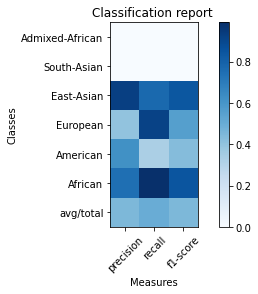

In [286]:
plot_classification_report(report,with_avg_total=True)

# Summary